[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Tutorial 1 - Spike Encoding
## By Jason K. Eshraghian (www.ncg.ucsc.edu)


<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_1_spikegen.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In this tutorial, you will learn how to use snnTorch to:
* convert datasets into spiking datasets, 
* how to visualise them, 
* and how to generate random spike trains.

# Introduction
Light is what we see when the retina converts photons into spikes. Odors are what we smell when volatilised molecules are converted into spikes. Touch is what we feel when nerve endings turn tactile pressure into spikes. The brain trades in the global currency of the *spike*. 

If our end goal is to build a spiking neural network (SNN), it makes sense to use spikes at the input too. Although it is quite common to use non-spiking inputs (as will be seen in Tutorial 3), part of the appeal of encoding data come from the *three S's*: spikes, sparsity, and static suppression.



1.   **Spikes**: (a-b) Biological neurons process and communicate via spikes, which are electrical impulses of approximately 100 mV in amplitude. (c) Many computational models of neurons simplify this voltage burst to a discrete, single-bit event: a '1' or a '0'. This is far simpler to represent in hardware than a high precision value.

2.   **Sparsity**: (c) Neurons spend most of their time at rest, silencing most activations to *zero* at any given time. Not only are sparse vectors/tensors (with loads of zeros) cheap to store, but say we need to multiply sparse activations with synaptic weights. If most values are multiplied by '0', then we don't need to read many of the network parameters from memory. This means neuromorphic hardware can be extremely efficient. 

3.   **Static-Suppression (a.k.a, event-driven processing**: (d-e) The sensory periphery only processes information when there is new information to process. Each pixel in (e) responds to *changes* in illuminance, so most of the image is blocked out. Conventional signal processing requires all channels/pixels to adhere to a global sampling/shutter rate, which slows down how frequently sensing can take place. Event-driven processing now only contributes to sparsity and power-efficiency by blocking unchanging input, but it often allows for much faster processing speeds.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/3s.png?raw=true' width="600">
</center>

In this tutorial, we will assume we have some non-spiking input data (i.e., the MNIST dataset) and that we want to encode it into spikes using a few different techniques. So let's get started! 

Install the latest PyPi distribution of snnTorch:

- !pip install snntorch

## 1. Setting up the MNIST Dataset

### 1.1. Import packages and setup environment

In [18]:
import snntorch as snn
import torch

In [19]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

### 1.2 Download Dataset

In [20]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)), #将输入图像调整28*28像素大小
            transforms.Grayscale(),#将图像转换为灰度图（单通道）
            transforms.ToTensor(),#将图像转换为 PyTorch 张量格式，并将像素值范围从 [0,255] 转换到 [0,1]
            transforms.Normalize((0,), (1,))])#对数据进行标准化处理，这里使用均值 0 和标准差 1
                                            #=======>这就像是把数据"归一"到一个统一的标尺上，使得模型能够更好地学习数据的特征，
                                            # 而不是被数值的绝对大小所干扰。

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)


一.不是所有数据集都需要完全相同的 transform 预处理流程。transform 的设计主要基于：

1. 数据集的本身特点：
```python
# MNIST (单通道灰度图)
transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# ImageNet (彩色图像)
transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
```

2. 任务需求：
- 分类任务可能需要数据增强
- 分割任务需要保持图像和掩码的对应关系
- 目标检测需要保持物体的位置信息

3. 特定场景：
- 医疗图像可能需要特殊的预处理
- 遥感图像可能需要多光谱处理
- 人脸识别可能需要特定的对齐操作

但一般都需要：
1. `ToTensor()`: 转换为张量格式
2. 某种形式的尺寸调整
3. 某种形式的归一化或标准化

关键是根据具体情况设计合适的预处理流程。

二.不是所有数据集都必须进行标准化，这取决于具体情况：

需要标准化的情况：
1. 特征尺度差异大的数据集
- 比如房价预测中，面积可能是100-1000，而房间数可能是1-10
- 金融数据中，有的指标是百分比，有的是具体金额

2. 深度学习模型
- 大多数深度神经网络对数据尺度比较敏感
- 特别是使用梯度下降优化的模型

不一定需要标准化的情况：
1. 决策树类模型
- 如随机森林、决策树等对数据尺度不敏感
- 因为它们基于数据的排序或分割点做决策

2. 数据本身已经在相似尺度
- 如果所有特征都已经在0-1范围内
- 或者特征本身就是类似尺度的（比如都是百分比）

3. 某些特定任务
- 需要保持原始数据的可解释性
- 或者数据的绝对大小本身就很重要

所以这个预处理步骤是否必要，主要取决于：
- 选择的模型类型
- 数据的特点
- 任务的具体需求

If the above code block throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [21]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)

Until we actually start training a network, we won't need large datasets.
`snntorch.utils` contains a few useful functions for modifying datasets. Apply `data_subset` to reduce the dataset by the factor defined in `subset`. *E.g., for `subset=10`, a training set of 60,000 will be reduced to 6,000.*


In [22]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


### 1.3 Create DataLoaders
The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

##### Question : train_loader 的工作原理

首先，让我们从最基础的概念开始理解：

想象你有一本很厚的相册（这就是你的整个训练数据集）。如果你想要查看照片，你不会一次性翻看所有照片，而是每次翻看几页。train_loader 就像是帮你自动翻页的助手。

train_loader 的主要功能包括：

1. 数据批次处理：
它会将大型数据集分割成小批次（batches）。比如，你可能有50,000张图片，但 train_loader 每次只给你128张。这样做有几个好处：
   - 节省内存：不需要一次性将所有数据载入内存
   - 加速训练：小批量训练能让模型更快收敛
   - 引入随机性：每个 epoch 的批次顺序都可以打乱，有助于模型学习

2. 数据预处理：
train_loader 可以在加载数据时自动进行一系列处理：
```python
train_loader = DataLoader(
    dataset,              # 数据集
    batch_size=128,       # 每批处理128张图片
    shuffle=True,         # 随机打乱数据
    num_workers=4         # 使用4个进程并行加载
)
```

3. 迭代机制：
当我们使用 train_loader 时，它提供了一个优雅的迭代接口：
```python
# 方法1：直接迭代
for batch_data, batch_labels in train_loader:
    # 处理这批数据
    pass

# 方法2：使用迭代器（就像你代码中展示的）
data = iter(train_loader)
batch_data, batch_labels = next(data)
```

在你展示的代码中：
```python
data = iter(train_loader)           # 创建迭代器
data_it, targets_it = next(data)    # 获取下一批数据和标签
```
这段代码做了两件事：
1. 将 train_loader 转换为迭代器
2. 使用 next() 获取一批数据，这批数据包含了图像数据（data_it）和对应的标签（targets_it）

这就像是：
- iter(train_loader) 是打开相册的动作
- next(data) 是翻到下一页的动作

对于 MNIST 数据集来说，每次 next() 会给你：
- data_it: 形状为 [128, 1, 28, 28] 的张量（128张图片，每张1个通道，28×28像素）
- targets_it: 形状为 [128] 的张量（128个标签，对应每张图片的数字）

理解 train_loader 的工作原理对于深度学习实践非常重要，因为它直接影响到你的模型训练效率和内存使用。你觉得这些概念中有哪些地方需要我进一步解释吗？

## 2. Spike Encoding

Spiking Neural Networks (SNNs) are made to exploit time-varying data. And yet, MNIST is not a time-varying dataset.
There are two options for using MNIST with an SNN:

1. Repeatedly pass the same training sample $\mathbf{X}\in\mathbb{R}^{m\times n}$ to the network at each time step. This is like converting MNIST into a static, unchanging video. Each element of $\mathbf{X}$ can take a high precision value normalized between 0 and 1: $X_{ij}\in [0, 1]$. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="700">
</center>

2. Convert the input into a spike train of sequence length `num_steps`, where each feature/pixel takes on a discrete value $X_{i,j} \in \{0, 1\}$.
In this case, MNIST is converted into a time-varying sequence of spikes that features a relation to the original image.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="700">
</center>


##### Question : 为什么原图像是完整的7，而第二种的不同时间的Input Data长成这个样子
这里展示的是一种称为"率编码"(rate coding)或"时间编码"(temporal coding)的技术，用于将静态图像转换为时间序列的脉冲。

想象一下这个过程：
1. 原始图像是一个静态的"7"，每个像素都有一个灰度值（比如0-255之间）。

2. 为了转换成脉冲序列，系统会在不同的时间点（t=0,1,2,3...）对图像进行采样或切片。在每个时间点，只有某些像素会被激活（发放脉冲）。

3. 那些在Input Data中看到的零散的点实际上是原始图像在不同时间点的"切片"。如果我们把所有时间点的切片叠加起来，就会得到完整的"7"。

举个具体的例子来说明这个过程：
- 假设一个像素的灰度值是200（比较亮）
- 在100个时间步长中，这个像素可能会在80个时间步发放脉冲
- 而灰度值是50的像素（比较暗）可能只在20个时间步发放脉冲

这种编码方式的优势是：
- 将静态信息转换为时间序列信息，更接近生物神经系统的工作方式
- 可以根据像素的强度来调整脉冲发放的频率
- 使得网络能够逐步处理信息，而不是一次性处理所有信息

这就是为什么在图中看到的Input Data是散点状的 - 它代表了原始图像在不同时间点的部分激活状态，每个时间点都只显示部分像素的脉冲发放。


The first method is quite straightforward, and does not fully exploit the temporal dynamics of SNNs. So let’s consider data-to-spike conversion (encoding) from (2) in more detail.

The module `snntorch.spikegen` (i.e., spike generation) contains a series of functions that simplify the conversion of data into spikes. There are currently three options available for spike encoding in `snntorch`:

1. Rate coding: [`spikegen.rate`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate)
2. Latency coding: [`spikegen.latency`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.latency)
3. Delta modulation: [`spikegen.delta`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.delta)

How do these differ?


1.   *Rate coding* uses input features to determine spiking **frequency**
2.   *Latency coding* uses input features to determine spike **timing**
3.   *Delta modulation* uses the temporal **change** of input features to generate spikes


### 2.1 Rate coding of MNIST

One example of converting input data into a rate code is as follows. 
Each normalised input feature $X_{ij}$ is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value $R_{ij}$. This can be treated as a Bernoulli trial: $R_{ij}\sim B(n,p)$, where the number of trials is $n=1$, and the probability of success (spiking) is $p=X_{ij}$. Explicitly, the probability a spike occurs is:

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

Create a vector filled with the value '0.5' and encode it using the above technique:

In [24]:
# Temporal Dynamics
num_steps = 10

# create vector filled with 0.5;
# 0.5代表了神经元在任意时间步发放脉冲的概率
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 1.])
The output is spiking 50.00% of the time.


这种编码方式的实际意义是：

* 在处理MNIST图像时，每个像素的灰度值（归一化到0-1之间）就变成了发放脉冲的概率
* 较亮的像素（值接近1）会有更高的概率发放脉冲
* 较暗的像素（值接近0）发放脉冲的概率较低
* 此时，灰度值既代表像素亮度，又代表发放脉冲的概率

Now try again, but increasing the length of `raw_vector`:

In [25]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 50.00% of the time.


As `num_steps`$\rightarrow\infty$, the proportion of spikes approaches the original raw value.

For an MNIST image, this probability of spiking corresponds to the pixel value. A white pixel corresponds to a 100% probability of spiking, and a black pixel will never generate a spike. Take a look at the 'Rate Coding' column below for further intuition.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>

In a similar way, `spikegen.rate` can be used to generate a rate-coded sample of data. As each sample of MNIST is just an image, we can use `num_steps` to repeat it across time. 

In [26]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

If the input falls outside of $[0,1]$, this no longer represents a probability. Such cases are automatically clipped to ensure the feature represents a probability.

The structure of the input data is ``[num_steps x batch_size x input dimensions]``:

In [27]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


上述输出含义：
* 时间步长为 100
* 批次大小为 128
* 通道数为 1
* 图像大小为 28×28（这正好是 MNIST 数据集的图像尺寸）

其中，通道数含义：
* 黑白图像只有 1 个通道，因为每个像素点只需要一个数值来表示其亮度（从黑到白的程度）
* 彩色图像通常有 3 个通道，即 RGB（红、绿、蓝），每个像素需要三个数值来分别表示这三种颜色的强度

### 2.2 Visualization

#### 2.2.1 Animation
snnTorch contains a module [`snntorch.spikeplot`](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html) that simplifies the process of visualizing, plotting, and animating spiking neurons.


In [28]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

To plot one sample of data, index into a single sample from the batch (B) dimension of `spike_data`, ``[T x B x 1 x 28 x 28]``:

In [29]:
spike_data_sample = spike_data[:, 100, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


`spikeplot.animator` makes it super simple to animate 2-D data.<br>
Note: if you are running the notebook locally you may need to install ffmpeg: e.g., `pip install ffmpeg` or if in a Conda environment, `conda install -c conda-forge ffmpeg`.<br>
If ffmpeg is not found, please uncomment the line below and modify the path to your ffmpeg.exe.

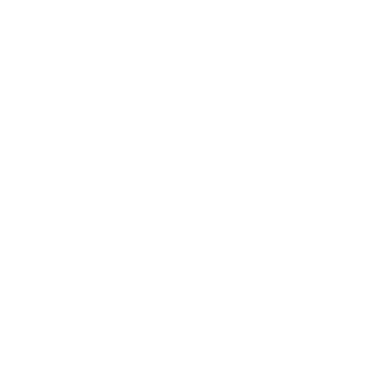

In [30]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

In [31]:
# If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
# anim.save("spike_mnist_test.mp4")

The associated target label can be indexed as follows:

In [32]:
print(f"The corresponding target is: {targets_it[100]}")

The corresponding target is: 2


MNIST features a greyscale image, and the white text guarantees a 100% of spiking at every time step. So let's do that again but reduce the spiking frequency. This can be achieved by setting the argument `gain`. Here, we will reduce spiking frequency to 25%.

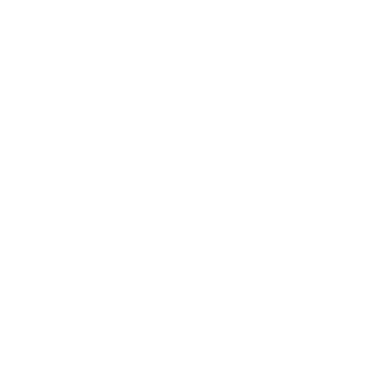

In [33]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 100, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())


##### gain=0.25 是一个控制参数，它影响脉冲生成的频率或强度。

在神经科学和脉冲神经网络中，gain（增益）是一个缩放因子，它决定了如何将输入信号转换为脉冲发放率。想象它像是一个音量旋钮：

- 当 gain 值较大时（比如 1.0），输入信号会被放大，导致更高的脉冲发放频率
- 当 gain 值较小时（比如 0.25），输入信号会被减弱，导致更低的脉冲发放频率

在您的代码中，gain=0.25 意味着输入数据会被缩小到原来的四分之一。这样做的原因可能是：

1. 控制脉冲密度：较低的 gain 值会产生更稀疏的脉冲模式，这通常更接近生物神经元的实际行为
2. 防止饱和：如果脉冲太密集，可能会导致网络性能下降
3. 能量效率：较低的发放率意味着更少的计算资源消耗

让我们通过一个具体的例子来理解：
假设您有一个像素值为 0.8 的输入：
- 如果 gain=1.0，这个像素产生脉冲的概率就是 0.8
- 而当 gain=0.25 时，这个概率会变成 0.8 × 0.25 = 0.2

这个参数的选择需要根据具体任务来权衡：太大的 gain 可能导致信息冗余，太小的 gain 则可能丢失重要信息。在实践中，通常需要通过实验来找到最优的 gain 值。


In [34]:
# Uncomment for optional save
# anim.save("spike_mnist_test2.mp4")

Now average the spikes out over time and reconstruct the input images.

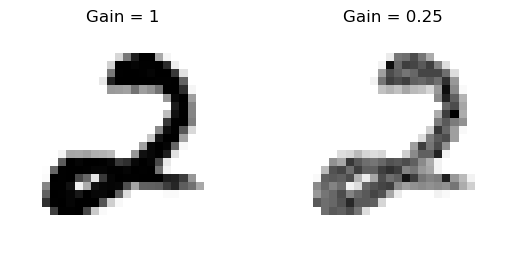

In [35]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

The case where `gain=0.25` is lighter than where `gain=1`, as spiking probability has been reduced by a factor of $\times 4$.

#### 2.2.2 Raster Plots
Alternatively, we can generate a raster plot of an input sample. This requires reshaping the sample into a 2-D tensor, where 'time' is the first dimension. Pass this sample into the function `spikeplot.raster`. 

### raster plot是什么？
想象您在观察一群音乐家在演奏交响乐。每个音乐家（就像神经元）在特定时刻演奏音符（发放脉冲）。Raster Plot 就像是这场音乐会的乐谱，它记录了"谁"在"什么时候"演奏了音符。
在神经科学的语境下：

- 纵轴（Y轴）代表不同的神经元，就像不同的音乐家
- 横轴（X轴）代表时间，就像乐谱上的小节线
- 每个小点代表一个脉冲（动作电位），就像乐谱上的音符

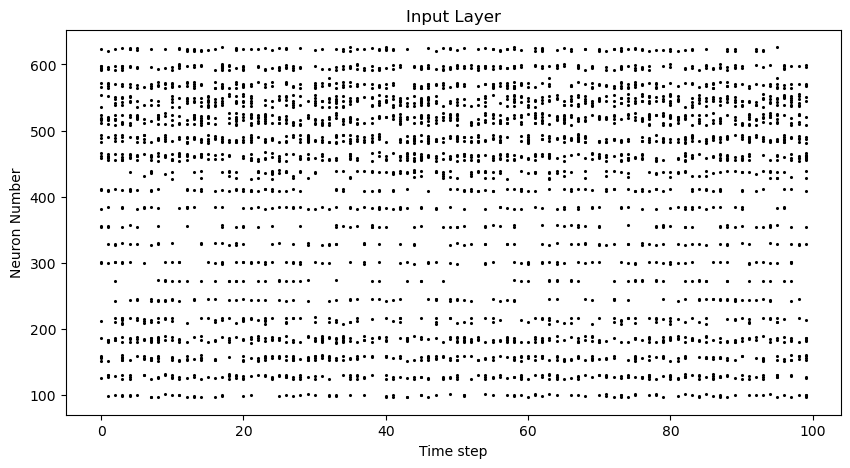

In [36]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The following code snippet shows how to index into one single neuron. 
Depending on the input data, you may need to try
a few different neurons between 0 & 784 before finding one that
spikes.

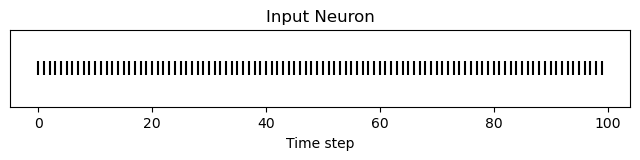

In [37]:
idx = 245  # index into 245th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

#### 2.2.3 Summary of Rate Coding
The idea of rate coding is actually quite controversial. Although we are fairly confident rate coding takes place at our sensory periphery, we are not convinced that the cortex globally encodes information as spike rates. A couple of compelling reasons why include:

*   **Power Consumption:** Nature optimised for efficiency. Multiple spikes are needed to achieve any sort of task, and each spike consumes power. In fact, [Olshausen and Field's work in "What is the other 85% of V1 doing?"](http://www.rctn.org/bruno/papers/V1-chapter.pdf) demonstrates that rate-coding can only explain, at most, the activity of 15% of neurons in the primary visual cortex (V1). It is unlikely to be the only mechanism within the brain, which is both resource-constrained and highly efficient.


*   **Reaction Response Times:** We know that the reaction time of a human is roughly around 250ms. If the average firing rate of a neuron in the human brain is on the order of 10Hz, then we can only process about 2 spikes within our reaction timescale.

So why, then, might we use rate codes if they are not optimal for power efficiency or latency? Even if our brain doesn't process data as a rate, we are fairly sure that our biological sensors do. The power/latency disadvantages are partially offset by showing huge noise robustness: it's fine if some of the spikes fail to generate, because there will be plenty more where they came from.

Additionally, you may have heard of the [Hebbian mantra of "neurons that fire together, wire together"](https://doi.org/10.2307/1418888). If there is plenty of spiking, this may suggest there is plenty of learning. In some cases where training SNNs proves to be challenging, encouraging more firing via a rate code is one possible solution.

Rate coding is almost certainly working in conjunction with other encoding schemes in the brain. We will consider these other encoding mechanisms in the following sections. 
This covers the `spikegen.rate` function. Further information [can be found in the documentation here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).



首先，什么是脉冲率编码？
这是一种神经信息编码方式，通过神经元发放脉冲的频率来传递信息。就像摩尔斯电码通过点击的频率传递信息一样。虽然我们确定这种编码方式在感觉器官中存在，但科学家们对它是否是大脑皮层的主要编码方式持怀疑态度。
1. 怀疑的两个主要理由：

    1.1  能量消耗问题：


    - 自然界总是倾向于选择最高效的方式
    - 脉冲率编码需要多次脉冲才能完成任务，每次脉冲都需要消耗能量
    - 研究表明，在初级视觉皮层（V1）中，只有约15%的神经元活动可以用脉冲率编码解释
    - 考虑到大脑是一个高效且资源受限的系统，脉冲率编码不太可能是唯一的编码机制


    1.2 反应时间问题：


    - 人类的反应时间大约是250毫秒
    - 人脑神经元的平均发放频率约为10Hz（即每秒10次）
    - 这意味着在我们做出反应之前，每个神经元只能发放约2次脉冲
    - 这个数量似乎太少，难以支持复杂的信息处理

2. 那么，为什么我们还要使用脉冲率编码？
文章提出了几个原因：

- 我们的生物感受器确实使用这种编码方式
- 它具有很强的抗噪声能力：即使某些脉冲未能产生，仍有足够多的其他脉冲来传递信息
- 它与赫布理论（"一起发放的神经元会形成连接"）相符合
- 在训练脉冲神经网络时，增加发放率可能有助于学习

文章最后强调：脉冲率编码很可能只是大脑中众多编码方式中的一种，它与其他编码机制协同工作。这也说明了为什么我们需要继续研究和理解其他的神经编码机制。

### 2.3 Latency Coding of MNIST
Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency. While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms by orders of magnitude. 

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep.
Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later. 

The following block derives how this works. If you've forgotten circuit theory and/or the math means nothing to you, then don't worry! All that matters is: **big** input means **fast** spike; **small** input means **late** spike.


---
**Optional: Derivation of Latency Code Mechanism**

By default, spike timing is calculated by treating the input feature as the current injection $I_{in}$ into an RC circuit. This current moves charge onto the capacitor, which increases $V(t)$. We assume that there is a trigger voltage, $V_{thr}$, which once reached, generates a spike. The question then becomes: *for a given input current (and equivalently, input feature), how long does it take for a spike to be generated?*

Starting with Kirchhoff's current law, $I_{in} = I_R + I_C$, the rest of the derivation leads us to a logarithmic relationship between time and the input. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true' width="600">
</center>

---

The following function uses the above result to convert a feature of intensity $X_{ij}\in [0,1]$ into a latency coded response $L_{ij}$. 

In [38]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time 

Now, use the above function to visualize the relationship between input feature intensity and its corresponding spike time.


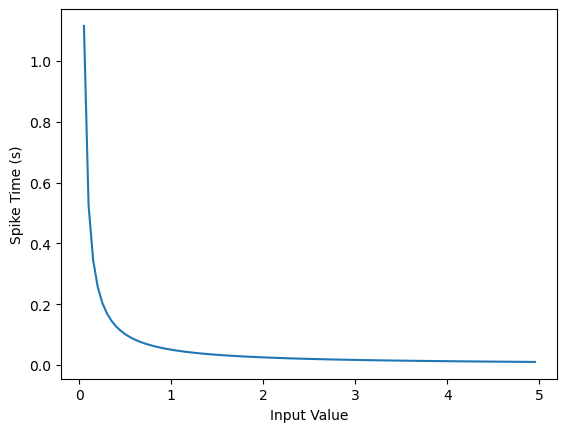

In [39]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

The smaller the value, the later the spike occurs with exponential dependence.

The vector `spike_times` contains the time at which spikes are triggered, rather than a sparse tensor that contains the spikes themselves (1's and 0's). 
When running an SNN simulation, we need the 1/0 representation to obtain all of the advantages of using spikes.
This whole process can be automated using `spikegen.latency`, where we pass a minibatch from the MNIST dataset in `data_it`:

In [40]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

Some of the arguments include:

* `tau`:  the RC time constant of the circuit. By default, the input features are treated as a constant current injected into an RC circuit. A higher ``tau`` will induce slower firing.
* `threshold`: the membrane potential firing threshold. Input values below this threshold do not have a closed-form solution, as the input current is insufficient to drive the membrane up to the threshold. All values below the threshold are clipped and assigned to the final time step.

#### 2.3.1 Raster plot

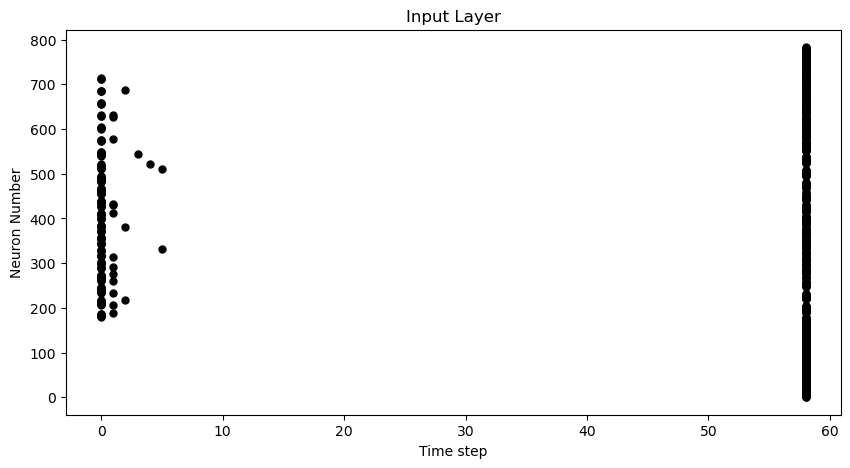

In [41]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

To make sense of the raster plot, note that high intensity features fire first, whereas low intensity features fire last:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="800">
</center>

The logarithmic code coupled with the lack of diverse input values (i.e., the lack of midtone/grayscale features) causes significant clustering in two areas of the plot.
The bright pixels induce firing at the start of the run, and the dark pixels at the end.
We can increase `tau` to slow down the spike times, or linearize the spike times by setting the optional argument `linear=True`.

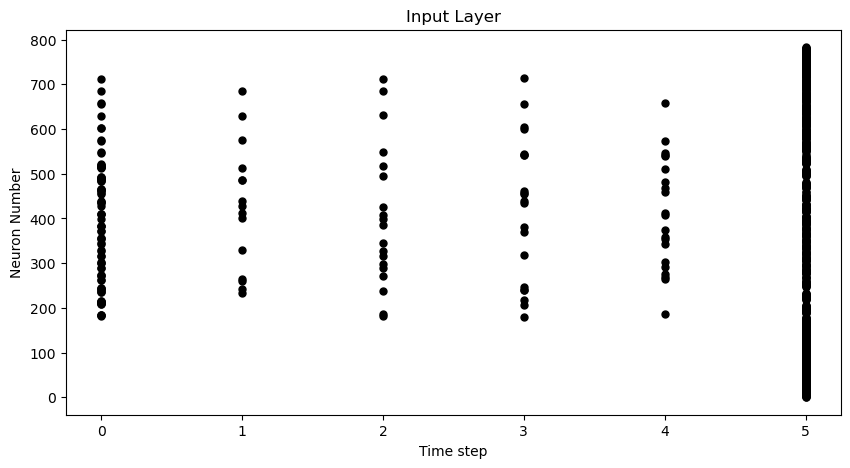

In [42]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

有关linearize的问题：
1. 没有线性化时（linear=False）：

- 亮像素会导致神经元在序列开始时快速发放
- 暗像素会导致神经元在序列末尾缓慢发放
- 这种不均匀的分布可能会造成信息的拥挤或稀疏

2. 启用线性化后（linear=True）：

- 系统会重新调整发放时间
- 使脉冲在整个时间窗口内更均匀地分布
- 避免了信息在某些时间点过于集中的问题

3. 线性化的好处是：

- 更好的时间编码效率
- 减少信息拥塞
- 可能提高网络的学习效果
- 使信息处理更加稳定

您可以在图中观察到，虽然神经元仍然在不同时间点发放，但分布变得更加均匀，不会出现极端的聚集现象。这就像是把拥挤的车流调节得更加顺畅，让信息传递更加高效。

The spread of firing times is much more evenly distributed now. This is achieved by linearizing the logarithmic equation according to the rules shown below. Unlike the RC model, there is no physical basis for the model. It's just simpler.
下面这幅图说明了linearize的原理：
<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_6_latencylinear.png?raw=true' width="600">
</center>


But note how all firing occurs within the first ~5 time steps, whereas the simulation range is 100 time steps. 
This indicates that we have a lot of redundant time steps doing nothing. This can be solved by either increasing `tau` to slow down the time constant, or setting the optional argument `normalize=True` to span the full range of `num_steps`.

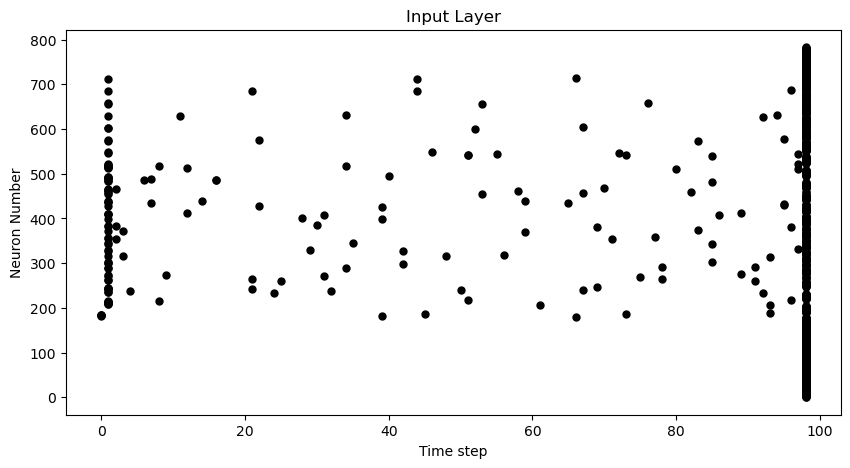

In [43]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

One major advantage of latency coding over rate coding is sparsity. If neurons are constrained to firing a maximum of once over the time course of interest, then this promotes low-power operation.

In the scenario shown above, a majority of the spikes occur at the final time step, where the input features fall below the threshold. In a sense, the dark background of the MNIST sample holds no useful information. 

We can remove these redundant features by setting `clip=True`.

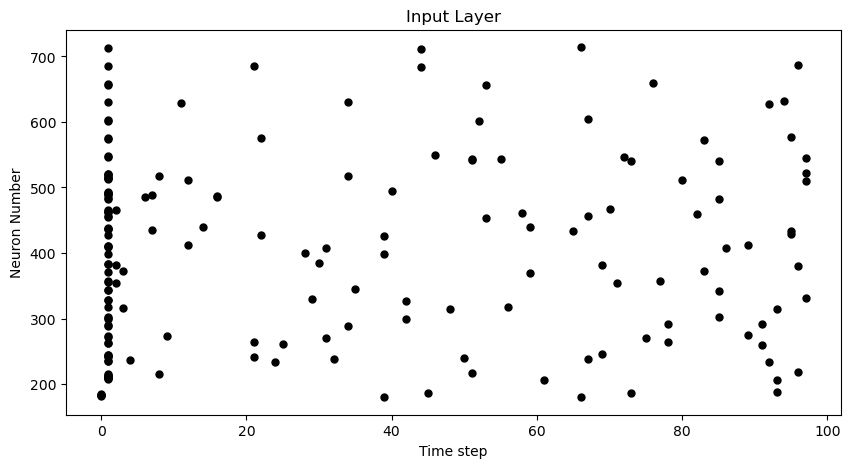

In [44]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, 
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

That looks much better!

#### 2.3.2 Animation
We will run the exact same code block as before to create an animation.

In [45]:
spike_data_sample = spike_data[:, 100, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


tips:
让我帮您深入理解这个三维切片操作 `spike_data[:, 100, 0]`。这比我们之前看到的二维切片要复杂一些，所以让我们一步步来分析它的结构。

首先，让我们理解 `spike_data` 的三个维度是什么：
1. 第一个维度（由 `:` 表示）：表示所有的批次（batch）或样本
2. 第二个维度（数字 `100`）：表示特定的时间步
3. 第三个维度（数字 `0`）：表示特定的特征或通道

用一个生活中的比喻来说，想象您有一叠相册：
- 每本相册代表一个批次（第一维）
- 每个相册都有100页，代表时间步（第二维）
- 每页都有多张照片，代表特征（第三维）

所以 `spike_data[:, 100, 0]` 的意思是：
- "给我所有相册（`:`）中"
- "第100页（`100`）上的"
- "第一张照片（`0`）"

在神经网络的语境中，这具体表示：
- 选择所有批次的数据
- 在第100个时间步
- 第0个特征或通道的值

这种索引方式在分析神经网络的时间动态时特别有用，因为它让我们能够：
1. 观察特定时间点的网络状态
2. 比较不同样本在同一时间点的行为
3. 研究特定特征随时间的演变


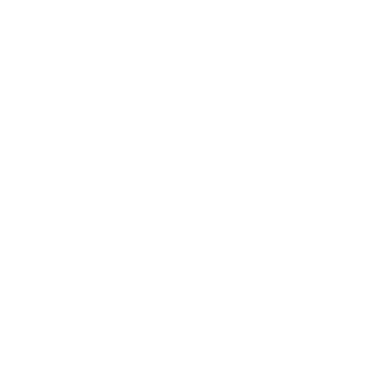

In [46]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

This animation is obviously much tougher to make out in video form, but a keen eye will be able to catch a glimpse of the initial frame where most of the spikes occur.
Index into the corresponding target value to check its value.

In [47]:
# Save output: .gif, .mp4 etc.
# anim.save("mnist_latency.gif")

In [48]:
print(targets_it[100])
# 通过打印target_it，判断是否正确加载与访问标签。

tensor(2)


That's it for the `spikegen.latency` function. Further information [can be found in the documentation here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).

### 2.4 Delta Modulation
There are theories that the retina is adaptive: it will only process information when there is something new to process. If there is no change in your field of view, then your photoreceptor cells are  less prone to firing. 

That is to say: **biology is event-driven**. Neurons thrive on change.

As a nifty example, a few researchers have dedicated their lives to designing retina-inspired image sensors, for example, the [Dynamic Vision Sensor](https://ieeexplore.ieee.org/abstract/document/7128412/). Although [the attached link is from over a decade ago, the work in this video](https://www.youtube.com/watch?v=6eOM15U_t1M&ab_channel=TobiDelbruck) was ahead of its time.

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both *positive* and *greater than the threshold $V_{thr}$*, a spike is generated:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_7_delta.png?raw=true' width="600">
</center>

To illustrate, let's first come up with a contrived example where we create our own input tensor.

- Tips:
不是单纯的点代表的大小，而是相邻两点差值代表的大小与阈值之间的关系

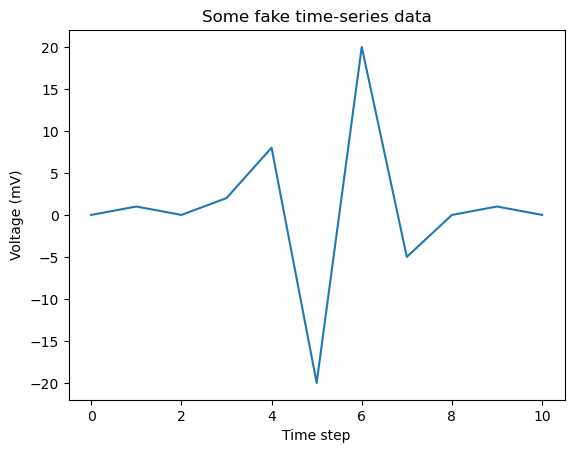

In [49]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

Pass the above tensor into the `spikegen.delta` function, with an arbitrarily selected `threshold=4`:

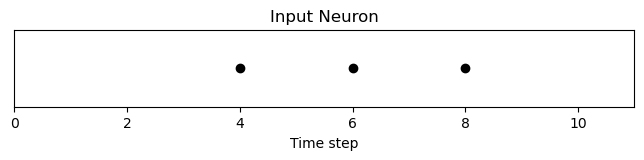

In [50]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

There are three time steps where the difference between $data[T]$ and $data[T+1]$ is greater than or equal to $V_{thr}=4$. This means there are three *on-spikes*. 

The large dip to $-20$ has not been captured above. If negative swings have importance in your data, you can enable the optional argument `off_spike=True`.

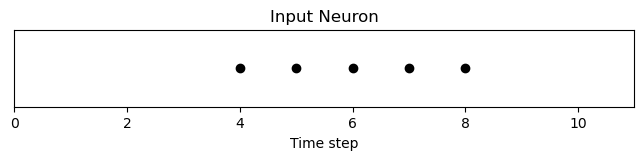

In [51]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

We've generated additional spikes, but this isn't actually the full picture! 

Printing out the tensor will show the presence of "off-spikes" which take on a value of `-1`.

In [52]:
print(spike_data)

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


While `spikegen.delta` has only been demonstrated on a fake sample of data, its true use is to compress time-series data by only generating spikes for sufficiently large changes/events. 

That wraps up the three main spike conversion functions! There are still additional features to each of the three conversion techniques that have not been detailed in this tutorial. In particular, we have only looked at encoding input data; we have not considered how we might encode targets, and when that is necessary. We recommend [referring to the documentation for a deeper dive](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).

## 3. Spike Generation (Optional)
Now what if we don't actually have any data to start with? 
Say we just want a randomly generated spike train from scratch. Inside of
`spikegen.rate` is a nested function, `rate_conv`, which actually performs the  spike conversion step.

All we have to do is initialize a randomly generated `torchTensor` to pass in.

In [53]:
# Create a random spike train
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)

### 3.1 Animation

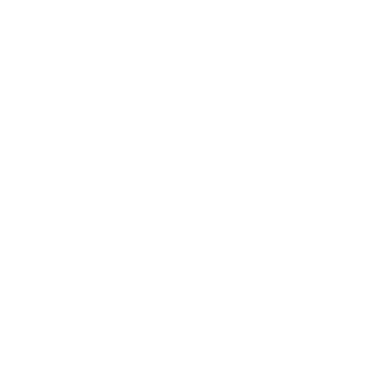

In [54]:
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

In [55]:
# Save output: .gif, .mp4 etc.
# anim.save("random_spikes.gif")

### 3.2 Raster

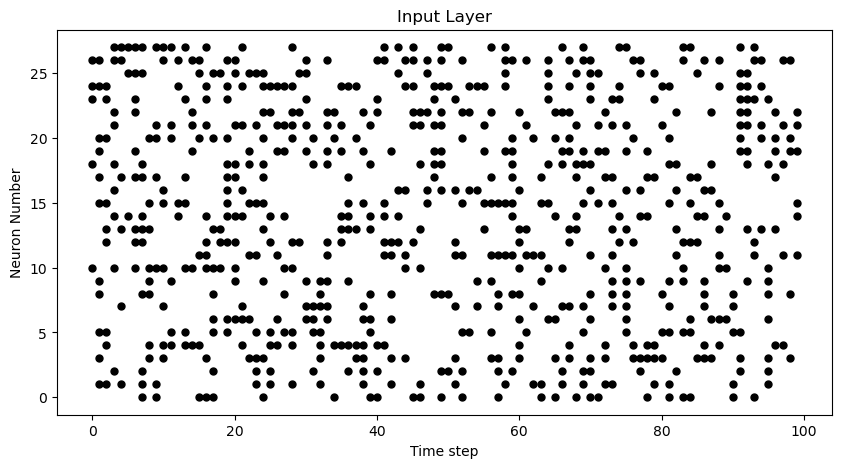

In [56]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# Conclusion

That's it for spike conversion and generation. 
This approach generalizes beyond images, to single-dimensional and multi-dimensional tensors.

For reference, the documentation for [`spikegen` can be found here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html) and for [`spikeplot`, here](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html)

[In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), you will learn the basics of spiking neurons and how to use them.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.

# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)